## 1. Loading the image data and Feature Extraction

In [56]:
import os
import numpy as np
import torch
from tensorflow.keras.preprocessing import image
from transformers import ViTImageProcessor, ViTModel
from tqdm import tqdm  # For progress visualization

# Ensure PyTorch uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the ViT feature extractor and model
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Move ViT model to GPU
vit_model.to(device)
vit_model.eval()

# Define paths for saving images
output_directory = '/content/drive/MyDrive/Mini Project - 2.0/data/processed_images/'
os.makedirs(output_directory, exist_ok=True)

# Function to load and preprocess images for a single subject
def load_and_preprocess_subject_images(subject_id, base_map_directory, output_directory):
    subject_directory = os.path.join(base_map_directory, f"sub-{subject_id:03d}")  # Pad subject ID to 3 digits
    subject_features = []  # To store features for each subject
    missing_files = []  # Log missing files for debugging

    # Check if subject directory exists
    if not os.path.exists(subject_directory):
        print(f"Subject folder {subject_directory} does not exist.")
        return None  # Skip this subject

    for segment in range(1, 20):  # Iterate through segments 1 to 19
        img_file = f"topo_maps_sub-{subject_id:03d}_segment_{segment}.png"
        img_path = os.path.join(subject_directory, img_file)

        print(f"Trying to load: {img_path}")

        # Check if the image file exists
        if os.path.exists(img_path):
            try:
                # Load and normalize the image
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]

                # Preprocess the image using the ViT processor with do_rescale=False
                processed_img = feature_extractor(img_array, return_tensors="pt", do_rescale=False)['pixel_values'].to(device)  # Move tensor to GPU

                # Extract features using the ViT model
                with torch.no_grad():  # Disable gradient calculation for inference
                    features = vit_model(processed_img).last_hidden_state  # Extract embeddings

                # Flatten the features and store them for this segment
                flattened_features = features.squeeze(0).mean(dim=0).cpu().numpy()  # Use mean of all tokens for 768 features
                subject_features.append(flattened_features)

                # Save each processed image separately
                image_output_path = os.path.join(output_directory, f"sub-{subject_id:03d}_segment_{segment}.npy")
                np.save(image_output_path, flattened_features)  # Save the flattened feature array
                print(f"Saved: {image_output_path}")

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        else:
            missing_files.append(img_file)  # Log missing files

    if len(subject_features) == 19:  # Ensure we have 19 segments for the subject
        subject_features = np.array(subject_features)  # Stack all features into a NumPy array
    else:
        print(f"Skipping subject {subject_id} due to missing segments.")
        subject_features = None

    if missing_files:
        print(f"Missing files for subject {subject_id}: {missing_files}")

    return subject_features

# Function to load and preprocess images for all subjects
def load_and_preprocess_all_subjects(num_subjects, base_map_directory, output_directory):
    eeg_images = []  # To store the features of all subjects
    for subject_id in tqdm(range(1, num_subjects + 1), desc="Processing Subjects"):
        subject_images = load_and_preprocess_subject_images(subject_id, base_map_directory, output_directory)
        if subject_images is not None:
            eeg_images.append(subject_images)
        else:
            print(f"Skipping subject {subject_id} due to missing or invalid images.")

    # Convert to a NumPy array with shape (88, 19, 768)
    eeg_images = np.array(eeg_images)
    return eeg_images

# Function to save the entire dataset as a .npz file
def save_to_npz(processed_images_all_subjects, output_file_path):
    # Save all subject images in a single .npz file
    np.savez_compressed(output_file_path, eeg_images=processed_images_all_subjects)
    print(f"Saved all processed images to {output_file_path}")

# Base directory for images
base_map_directory = '/content/drive/MyDrive/Mini Project - 2.0/data/images/'

# Process images for all the 88 subjects
eeg_images = load_and_preprocess_all_subjects(88, base_map_directory, output_directory)

# Save the processed images into a single .npz file
output_file_path = '/content/drive/MyDrive/Mini Project - 2.0/data/processed_images.npz'
save_to_npz(eeg_images, output_file_path)


Exception ignored in: <function _xla_gc_callback at 0x7b1536fb8b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import numpy as np

file_path = '/content/drive/MyDrive/Mini Project - 2.0/data/processed_images.npz'
data = np.load(file_path)

# List all keys in the .npz file
print(f"Keys in the .npz file: {data.files}")

eeg_images = data['eeg_images']  # Replace 'arr_0' with the actual key
print(f"Shape of eeg_images: {eeg_images.shape}")


## 2. Loading the EEG Data and Clinical data

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm  # For progress tracking

# Function to load clinical data
def load_clinical_data(tsv_file):
    """
    Load clinical data from a TSV file.

    Parameters:
        tsv_file (str): Path to the clinical data TSV file.

    Returns:
        pd.DataFrame: DataFrame with clinical data indexed by participant_id.
    """
    clinical_df = pd.read_csv(tsv_file, sep='\t')
    clinical_df.set_index('participant_id', inplace=True)
    return clinical_df

# Function to normalize data
def normalize_data(data, feature_range=(0, 1)):
    """
    Normalize data using MinMaxScaler.

    Parameters:
        data (np.array): Input data to normalize.
        feature_range (tuple): Desired range of transformed data.

    Returns:
        np.array: Normalized data.
    """
    scaler = MinMaxScaler(feature_range=feature_range)
    return scaler.fit_transform(data)

# Function to load EEG data
def load_subject_data(base_path, subjects, clinical_df, num_segments=19, num_channels=19, num_features=16):
    """
    Load EEG data for all subjects and combine with clinical data.

    Parameters:
        base_path (str): Path to the data directory.
        subjects (list): List of subject folder names in three-digit format (e.g., ['sub-001', 'sub-002']).
        clinical_df (pd.DataFrame): DataFrame with clinical data, indexed by participant_id.
        num_segments (int): Number of segments per subject.
        num_channels (int): Number of channels per segment (19 channels).
        num_features (int): Number of features per channel (16 features).

    Returns:
        tuple: EEG data array (num_subjects, num_segments, num_channels * num_features),
               Clinical data array (num_subjects, num_clinical_features),
               Labels array (num_subjects,).
    """
    eeg_data = []      # To store EEG features for each subject
    clinical_data = [] # To store clinical data for each subject
    labels = []        # To store labels (A/F/C) for each subject

    # Iterate over each subject directory
    for subject in tqdm(subjects, desc="Loading Subjects"):
        subject_path = os.path.join(base_path, subject)
        subject_segments = []

        # Load each segment CSV file
        for i in range(1, num_segments + 1):
            segment_file = os.path.join(subject_path, f'{subject}_task-eyeclosed_eeg_segment-{i}_features.csv')

            if not os.path.exists(segment_file):
                print(f"Warning: File {segment_file} not found. Skipping segment.")
                continue

            segment_df = pd.read_csv(segment_file, header=None)
            segment_df = segment_df.apply(pd.to_numeric, errors='coerce')
            segment_df = segment_df.dropna(axis=1, how='all').dropna(axis=0, how='any')
            segment_flat = segment_df.values.flatten()
            subject_segments.append(segment_flat)

        if len(subject_segments) != num_segments:
            print(f"Warning: Incomplete data for {subject}. Skipping this subject.")
            continue

        subject_segments = np.array(subject_segments)
        eeg_data.append(subject_segments)

        clinical_info = clinical_df.loc[subject]
        clinical_features = clinical_info[['Age', 'Gender', 'MMSE']].values

        if isinstance(clinical_features[1], str):
            clinical_features[1] = 1 if clinical_features[1].lower() == 'male' else 0

        label = clinical_info['Group']
        clinical_data.append(clinical_features)
        labels.append(label)

    eeg_data = np.array(eeg_data)
    clinical_data = np.array(clinical_data)
    labels = np.array(labels)

    return eeg_data, clinical_data, labels

# Main script
if __name__ == "__main__":
    # Define paths
    tsv_file = '/content/drive/MyDrive/Mini Project - 2.0/data/participants_updated.tsv'
    base_path = '/content/drive/MyDrive/Mini Project - 2.0/data/temporal_features'
    subjects = [f'sub-{i:03}' for i in range(1, 89)]

    # Load clinical data
    clinical_df = load_clinical_data(tsv_file)

    # Load EEG and clinical data
    eeg_data, clinical_data, labels = load_subject_data(base_path, subjects, clinical_df)

    # Normalize EEG data
    eeg_data_normalized = []
    for subject in eeg_data:
        subject_normalized = []
        for segment in subject:
            segment = segment.reshape(19, 16)  # Reshape back to (num_channels, num_features)
            segment_normalized = normalize_data(segment)  # Normalize each channel's features
            subject_normalized.append(segment_normalized)
        eeg_data_normalized.append(subject_normalized)

    # Convert to numpy array with shape (88, 19, 19, 16)
    eeg_signal = np.array(eeg_data_normalized)

    # Normalize clinical data
    eeg_clinical = normalize_data(clinical_data)

    # Print shapes for verification
    print(f"Shape of eeg_signal: {eeg_signal.shape}")  # (88, 19, 19, 16)
    print(f"Shape of eeg_clinical: {eeg_clinical.shape}")  # (88, 3)

    # Save normalized data
    np.save('/content/drive/MyDrive/Mini Project - 2.0/data/eeg_signal.npy', eeg_signal)
    np.save('/content/drive/MyDrive/Mini Project - 2.0/data/eeg_clinical.npy', eeg_clinical)
    print("Normalized data saved successfully.")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load the clinical data
clinical_tsv_file = '/content/drive/MyDrive/Mini Project - 2.0/data/participants_updated.tsv'
clinical_df = pd.read_csv(clinical_tsv_file, sep='\t')

# Check the unique values in the 'Group' column
print(f"Unique values in 'Group' column: {clinical_df['Group'].unique()}")

# If the 'Group' column already contains numeric labels (0, 1, 2), we can directly use these
# without mapping them again. We will just one-hot encode them.

# One-hot encode the labels (assuming they are numeric)
def one_hot_encode_labels(labels):
    encoder = OneHotEncoder(sparse_output=False, categories='auto')  # Corrected argument for non-sparse output
    labels_encoded = encoder.fit_transform(labels.reshape(-1, 1))
    return labels_encoded

# One-hot encode the labels
one_hot_labels = one_hot_encode_labels(clinical_df['Group'].values)

# Save the one-hot encoded labels
np.save('/content/drive/MyDrive/Mini Project - 2.0/data/one_hot_labels.npy', one_hot_labels)

# Output confirmation
print(f"Shape of one_hot_labels: {one_hot_labels.shape}")
print("One-hot encoded labels saved successfully.")


## 3. Analysing the Dataset (npy arrays)

In [1]:
import numpy as np

# Load the data files
file_path = '/content/drive/MyDrive/Mini Project - 2.0/data/processed_images.npz'
data = np.load(file_path)
eeg_images = data['eeg_images']

eeg_clinical = np.load('/content/drive/MyDrive/Mini Project - 2.0/data/eeg_clinical.npy')
eeg_signal = np.load('/content/drive/MyDrive/Mini Project - 2.0/data/eeg_signal.npy')
labels = np.load('/content/drive/MyDrive/Mini Project - 2.0/data/one_hot_labels.npy')


# Check the shape of the loaded data to confirm they are correct
print(f"eeg_images shape: {eeg_images.shape}")
print(f"eeg_clinical shape: {eeg_clinical.shape}")
print(f"eeg_signal shape: {eeg_signal.shape}")
print(f"labels shape: {labels.shape}")


eeg_images shape: (88, 19, 768)
eeg_clinical shape: (88, 3)
eeg_signal shape: (88, 19, 19, 16)
labels shape: (88, 3)


In [2]:
import numpy as np

# Assuming eeg_signal has the shape (88, 19, 19, 16)
print(f"Original shape of eeg_signal: {eeg_signal.shape}")

# Reshape the eeg_signal from (88, 19, 19, 16) to (88, 19, 304)
eeg_signal_res = eeg_signal.reshape(88, 19, 304)

# Check the new shape
print(f"New shape of eeg_signal: {eeg_signal_res.shape}")
eeg_signal = eeg_signal_res

# Assuming eeg_signal has the shape (88, 19, 19, 16)
print(f"Updating the variable shape of eeg_signal: {eeg_signal.shape}")

Original shape of eeg_signal: (88, 19, 19, 16)
New shape of eeg_signal: (88, 19, 304)
Updating the variable shape of eeg_signal: (88, 19, 304)


In [3]:
# Check mean and standard deviation for each dataset
print("Checking normalization for eeg_images...")
print(f"Mean of eeg_images: {np.mean(eeg_images)}")
print(f"Standard deviation of eeg_images: {np.std(eeg_images)}")

print("Checking normalization for eeg_clinical...")
print(f"Mean of eeg_clinical: {np.mean(eeg_clinical)}")
print(f"Standard deviation of eeg_clinical: {np.std(eeg_clinical)}")

print("Checking normalization for eeg_signal...")
print(f"Mean of eeg_signal: {np.mean(eeg_signal)}")
print(f"Standard deviation of eeg_signal: {np.std(eeg_signal)}")


Checking normalization for eeg_images...
Mean of eeg_images: -0.018560945987701416
Standard deviation of eeg_images: 0.16616365313529968
Checking normalization for eeg_clinical...
Mean of eeg_clinical: 0.6206751581751583
Standard deviation of eeg_clinical: 0.3537602168197255
Checking normalization for eeg_signal...
Mean of eeg_signal: 0.37288930747104165
Standard deviation of eeg_signal: 0.2990867831426366


In [4]:
eeg_images.shape

(88, 19, 768)

In [5]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()

# Standardize eeg_images (keep the same shape)
eeg_images_standardized = scaler.fit_transform(eeg_images.reshape(-1, eeg_images.shape[-1])).reshape(eeg_images.shape)

# Standardize eeg_clinical (already 2D, so no reshape needed)
eeg_clinical_standardized = scaler.fit_transform(eeg_clinical)

# Standardize eeg_signal: Reshape from 3D to 2D, then back to 3D
# Assuming eeg_signal has shape (samples, channels, time)
eeg_signal_reshaped = eeg_signal.reshape(-1, eeg_signal.shape[-1])  # Flatten the samples and channels/dimensions
eeg_signal_standardized = scaler.fit_transform(eeg_signal_reshaped)  # Standardize the reshaped data
eeg_signal_standardized = eeg_signal_standardized.reshape(eeg_signal.shape)  # Reshape back to original 3D shape

# Check the statistics again
print(f"Standardized eeg_images mean: {np.mean(eeg_images_standardized)}, std: {np.std(eeg_images_standardized)}")
print(f"Standardized eeg_clinical mean: {np.mean(eeg_clinical_standardized)}, std: {np.std(eeg_clinical_standardized)}")
print(f"Standardized eeg_signal mean: {np.mean(eeg_signal_standardized)}, std: {np.std(eeg_signal_standardized)}")


Standardized eeg_images mean: -5.243331324678024e-10, std: 1.0
Standardized eeg_clinical mean: 2.6914497566670462e-17, std: 1.0
Standardized eeg_signal mean: 1.1153254094650985e-16, std: 0.9999999999999998


In [6]:
# Check the shape of the loaded data to confirm they are correct
print(f"eeg_images shape: {eeg_images_standardized.shape}")
print(f"eeg_clinical shape: {eeg_clinical_standardized.shape}")
print(f"eeg_signal shape: {eeg_signal_standardized.shape}")
print(f"labels shape: {labels.shape}")

eeg_images shape: (88, 19, 768)
eeg_clinical shape: (88, 3)
eeg_signal shape: (88, 19, 304)
labels shape: (88, 3)


In [7]:
# Save the standardized data
#np.save('/content/drive/MyDrive/Mini Project - 2.0/data/eeg_images_standardized.npy', eeg_images_standardized)
#np.save('/content/drive/MyDrive/Mini Project - 2.0/data/eeg_clinical_standardized.npy', eeg_clinical_standardized)
#np.save('/content/drive/MyDrive/Mini Project - 2.0/data/eeg_signal_standardized.npy', eeg_signal_standardized)

#print("Standardized data saved successfully!")


## 4. Building the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# EEG Input
eeg_input = Input(shape=(19, 304), name='eeg_input')  # Reshaped EEG signal data (19 channels, 304 features)
x1 = LSTM(32, return_sequences=False)(eeg_input)  # Reduced LSTM units
x1 = Dropout(0.2)(x1)

# Clinical Input
clinical_input = Input(shape=(3,), name='clinical_input')  # 3 features (Age, Gender, MMSE)
x2 = Dense(16, activation='relu')(clinical_input)  # Reduced dense units
x2 = Dropout(0.2)(x2)

# Image Features Input
image_input = Input(shape=(19, 768), name='image_input')  # 19 segments, each with 768 extracted features
x3 = Conv1D(64, kernel_size=3, activation='relu')(image_input)  # Reduced number of filters
x3 = MaxPooling1D(pool_size=2)(x3)
x3 = Flatten()(x3)
x3 = Dropout(0.2)(x3)

# Concatenate EEG, Clinical, and Image features
combined = Concatenate()([x1, x2, x3])

# Add Dense Layers after Concatenation
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(combined)  # Reduced dense layer size
x = Dropout(0.2)(x)

# Output Layer
output = Dense(3, activation='softmax')(x)  # For multi-class classification (adjust as per your problem)

# Define the model
model = Model(inputs=[eeg_input, clinical_input, image_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 19, 768)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 17, 64)         │        147,520 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ eeg_input (InputLayer)    │ (None, 19, 304)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ clinical_input            │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 8, 64)          │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32)             │         43,136 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │             64 │ clinical_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 512)            │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 560)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0],       │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │         17,952 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │             99 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 208,771 (815.51 KB)

 Trainable params: 208,771 (815.51 KB)

 Non-trainable params: 0 (0.00 B)

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split
eeg_train_val, eeg_test, clinical_train_val, clinical_test, image_train_val, image_test, y_train_val, y_test = train_test_split(
    eeg_signal_standardized, eeg_clinical_standardized, eeg_images_standardized, labels, test_size=0.1, random_state=42
)

eeg_train, eeg_val, clinical_train, clinical_val, image_train, image_val, y_train, y_val = train_test_split(
    eeg_train_val, clinical_train_val, image_train_val, y_train_val, test_size=0.1, random_state=42
)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [13]:
# 5. Train the Model
history = model.fit(
    [eeg_train, clinical_train, image_train],  # Input features
    y_train,  # Labels
    validation_data=([eeg_val, clinical_val, image_val], y_val),  # Validation data
    epochs=20,  # You can adjust the number of epochs
    batch_size=16,  # Batch size
    callbacks=[early_stopping, checkpoint],  # Callbacks for early stopping and saving the best model
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.2540 - loss: 2.7405 - val_accuracy: 0.2500 - val_loss: 2.4063
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6524 - loss: 1.3837 - val_accuracy: 0.1250 - val_loss: 2.6538
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7954 - loss: 1.0565 - val_accuracy: 0.1250 - val_loss: 2.6424
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8788 - loss: 0.8997 - val_accuracy: 0.1250 - val_loss: 2.4685
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9081 - loss: 0.7997 - val_accuracy: 0.1250 - val_loss: 2.6231
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8791 - loss: 0.8288 - val_accuracy: 0.1250 - val_loss: 2.8429


In [14]:
# 6. Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate([eeg_test, clinical_test, image_test], y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4444 - loss: 1.8444
Test Loss: 1.8444, Test Accuracy: 0.4444


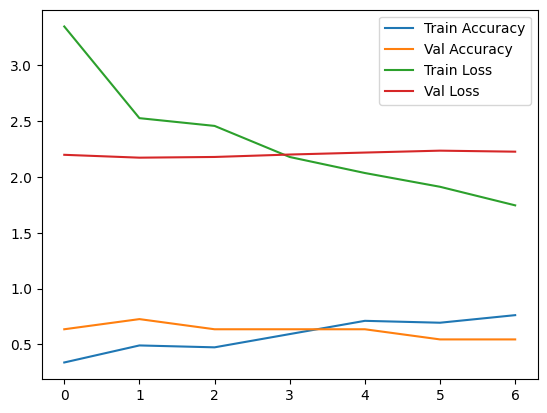

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 5. Hyperparameter tuning

In [15]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.8 MB/s eta 0:00:00


In [16]:
import kerastuner as kt

def build_model(hp):
    eeg_input = Input(shape=(19, 304), name='eeg_input')
    x1 = LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64), return_sequences=True)(eeg_input)
    x1 = LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64))(x1)
    x1 = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x1)

    clinical_input = Input(shape=(3,), name='clinical_input')
    x2 = Dense(32, activation='relu')(clinical_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x2)

    image_input = Input(shape=(19, 768), name='image_input')
    x3 = Conv1D(hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=hp.Int('kernel_size', 3, 7, 1), activation='relu')(image_input)
    x3 = MaxPooling1D(pool_size=hp.Int('pool_size', 2, 4, 1))(x3)
    x3 = Flatten()(x3)
    x3 = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x3)

    combined = Concatenate()([x1, x2, x3])

    x = Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(combined)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=[eeg_input, clinical_input, image_input], outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter search
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, hyperband_iterations=2)
tuner.search(x=[eeg_train, clinical_train, image_train], y=y_train, validation_data=([eeg_val, clinical_val, image_val], y_val))
best_model = tuner.get_best_models(1)[0]
best_model.summary()


<ipython-input-16-f0305f94b517>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


NameError: name 'BatchNormalization' is not defined

In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Flatten, BatchNormalization,
    Conv1D, MaxPooling1D, Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# EEG Input
eeg_input = Input(shape=(19, 304), name='eeg_input')
x1 = LSTM(128, return_sequences=True)(eeg_input)
x1 = LSTM(128, return_sequences=False)(x1)
x1 = Dropout(0.5)(x1)  # Increased dropout to reduce overfitting

# Clinical Input
clinical_input = Input(shape=(3,), name='clinical_input')
x2 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(clinical_input)  # Added L2 regularization
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)  # Increased dropout rate

# Image Features Input
image_input = Input(shape=(19, 768), name='image_input')
x3 = Conv1D(96, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(image_input)  # Added L2 regularization
x3 = MaxPooling1D(pool_size=2)(x3)
x3 = Flatten()(x3)
x3 = Dropout(0.5)(x3)  # Increased dropout rate

# Concatenate EEG, Clinical, and Image features
combined = Concatenate()([x1, x2, x3])

# Dense Layers after Concatenation
x = Dense(192, activation='relu', kernel_regularizer=l2(0.01))(combined)  # Added L2 regularization
x = Dropout(0.5)(x)  # Increased dropout rate
output = Dense(3, activation='softmax')(x)

# Define the model
best_model = Model(inputs=[eeg_input, clinical_input, image_input], outputs=output)

# Compile the model with the best learning rate
best_model.compile(
    optimizer=Adam(learning_rate=0.000351),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with early stopping
history = best_model.fit(
    [eeg_train, clinical_train, image_train], y_train,
    validation_data=([eeg_val, clinical_val, image_val], y_val),
    epochs=50,  # Adjust based on validation performance
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
y_pred = best_model.predict([eeg_val, clinical_val, image_val])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


### Test Set

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(
    [eeg_test, clinical_test, image_test], y_test
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


## 6. Cross- Validation

In [9]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Stratified K-Fold Cross-Validation setup (5-fold)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_no = 1
for train_index, val_index in kfold.split(eeg_signal_standardized, labels.argmax(1)):  # Only use labels for stratification
    print(f"Training fold {fold_no}...")

    # Split the data into training and validation sets for this fold
    X_train_eeg = eeg_signal_standardized[train_index]
    X_val_eeg = eeg_signal_standardized[val_index]
    X_train_clinical = eeg_clinical_standardized[train_index]
    X_val_clinical = eeg_clinical_standardized[val_index]
    X_train_image = eeg_images_standardized[train_index]
    X_val_image = eeg_images_standardized[val_index]
    y_train = labels[train_index]
    y_val = labels[val_index]

    # Define the model
    eeg_input = Input(shape=(19, 304), name='eeg_input')  # Adjust shape if needed
    x1 = LSTM(32, return_sequences=False)(eeg_input)  # Reduced LSTM units
    x1 = Dropout(0.2)(x1)

    clinical_input = Input(shape=(3,), name='clinical_input')  # 3 features
    x2 = Dense(16, activation='relu')(clinical_input)  # Reduced dense units
    x2 = Dropout(0.2)(x2)

    image_input = Input(shape=(19, 768), name='image_input')  # 19 segments, each with 768 features
    x3 = Conv1D(64, kernel_size=3, activation='relu')(image_input)  # Reduced filters
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Flatten()(x3)
    x3 = Dropout(0.2)(x3)

    # Concatenate EEG, Clinical, and Image features
    combined = Concatenate()([x1, x2, x3])

    # Add Dense Layers after Concatenation
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(combined)  # Reduced dense layer size
    x = Dropout(0.2)(x)

    # Output Layer
    output = Dense(3, activation='softmax')(x)  # For multi-class classification

    # Define the model
    model = Model(inputs=[eeg_input, clinical_input, image_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for this fold
    model.fit([X_train_eeg, X_train_clinical, X_train_image], y_train, epochs=10, batch_size=32, verbose=1)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate([X_val_eeg, X_val_clinical, X_val_image], y_val, verbose=0)
    print(f"Validation accuracy for fold {fold_no}: {val_accuracy:.4f}")

    fold_no += 1


Training fold 1...
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2570 - loss: 2.5006
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6377 - loss: 1.3748
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7382 - loss: 1.1620
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8255 - loss: 1.0740
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9191 - loss: 0.8490
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9308 - loss: 0.8188
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9088 - loss: 0.8085
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9459 - loss: 0.7549
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9434 - loss: 0.7543 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9434 - loss: 0.6872


Validation accuracy for fold 1: 0.5556
Training fold 2...
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2525 - loss: 4.0848
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4753 - loss: 2.0254
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7869 - loss: 1.1412 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7728 - loss: 1.1471 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9537 - loss: 0.8377
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9112 - loss: 0.8681 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9434 - loss: 0.7789 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9332 - loss: 0.7588
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9269 - loss: 0.7375
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9639 - loss: 0.6310
Validation accuracy for fold 2: 0.4444
Training fold 3...
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step 

## Grid Search

In [32]:
pip install keras_tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [36]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, Concatenate, Flatten
from tensorflow.keras.models import Model

# Define the model-building function for Bayesian optimization
def build_model(hp):
    # EEG Input
    eeg_input = Input(shape=(19, 304), name='eeg_input')
    x1 = LSTM(hp.Int('lstm_units', min_value=64, max_value=128, step=32), return_sequences=False)(eeg_input)
    x1 = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1))(x1)

    # Clinical Input
    clinical_input = Input(shape=(3,), name='clinical_input')
    x2 = Dense(hp.Int('dense_units', min_value=32, max_value=64, step=16), activation='relu')(clinical_input)
    x2 = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1))(x2)

    # Image Features Input
    image_input = Input(shape=(19, 768), name='image_input')
    x3 = Conv1D(64, kernel_size=3, activation='relu')(image_input)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Flatten()(x3)
    x3 = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1))(x3)

    # Concatenate EEG, Clinical, and Image features
    combined = Concatenate()([x1, x2, x3])

    # Dense Layers after Concatenation
    x = Dense(hp.Int('dense_2_units', min_value=32, max_value=64, step=16), activation='relu')(combined)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1))(x)

    # Output Layer
    output = Dense(3, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=[eeg_input, clinical_input, image_input], outputs=output)

    # Optimizer and learning rate hyperparameter
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Initialize the tuner with the correct oracle configuration
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',  # We are optimizing validation accuracy
    max_trials=20,  # Increased the number of trials for better optimization
    executions_per_trial=1,  # Each trial will run once
    directory='bayesian_optimization',  # Directory for saving results
    project_name='eeg_model',  # Project name
    overwrite=True  # Overwrite previous results
)

# Adding early stopping callback to save computation time during optimization
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start the hyperparameter search
tuner.search(
    [eeg_signal_standardized, eeg_clinical_standardized, eeg_images_standardized],
    labels,
    epochs=20,  # Increased epochs for better training during optimization
    batch_size=32,
    validation_split=0.1,  # 10% of data for validation
    callbacks=[early_stopping]  # Apply early stopping to avoid overfitting
)

# Get the best hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters found: ", best_hps.values)

# Optionally, you can retrieve the best model and evaluate on a separate test set
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate([eeg_signal_standardized, eeg_clinical_standardized, eeg_images_standardized], labels)


Trial 20 Complete [00h 00m 08s]
val_accuracy: 0.2222222238779068

Best val_accuracy So Far: 0.7777777910232544
Total elapsed time: 00h 02m 42s
Best Hyperparameters found:  {'lstm_units': 64, 'dropout_rate': 0.30000000000000004, 'dense_units': 64, 'dense_2_units': 64, 'learning_rate': 0.002395527782587919}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5146 - loss: 0.9926 


[0.8740225434303284, 0.5681818127632141]

## Retraining Model

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Initialize variables to track the best fold
best_fold_index = -1
best_val_accuracy = 0
best_y_true = None
best_y_pred = None
best_model = None

# Start the cross-validation process
for fold_no, (train_index, val_index) in enumerate(skf.split(X_eeg, y_labels.argmax(1))):
    print(f"Training fold {fold_no + 1}...")

    # Split data into training and validation sets
    X_train_eeg, X_val_eeg = X_eeg[train_index], X_eeg[val_index]
    X_train_clinical, X_val_clinical = X_clinical[train_index], X_clinical[val_index]
    X_train_images, X_val_images = X_images[train_index], X_images[val_index]
    y_train, y_val = y_labels[train_index], y_labels[val_index]

    # Define the model for this fold
    eeg_input = Input(shape=(X_train_eeg.shape[1], X_train_eeg.shape[2]), name='eeg_input')
    x1 = LSTM(best_hyperparameters['lstm_units'], return_sequences=False)(eeg_input)
    x1 = Dropout(best_hyperparameters['dropout_rate'])(x1)

    clinical_input = Input(shape=(X_train_clinical.shape[1],), name='clinical_input')
    x2 = Dense(best_hyperparameters['dense_units'], activation='relu')(clinical_input)
    x2 = Dropout(best_hyperparameters['dropout_rate'])(x2)

    image_input = Input(shape=(X_train_images.shape[1], X_train_images.shape[2]), name='image_input')
    x3 = Conv1D(64, kernel_size=3, activation='relu')(image_input)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Flatten()(x3)
    x3 = Dropout(best_hyperparameters['dropout_rate'])(x3)

    # Concatenate all inputs
    combined = Concatenate()([x1, x2, x3])

    # Dense layers
    x = Dense(best_hyperparameters['dense_2_units'], activation='relu')(combined)
    x = Dropout(best_hyperparameters['dropout_rate'])(x)

    # Output layer
    output = Dense(3, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=[eeg_input, clinical_input, image_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the training data
    model.fit([X_train_eeg, X_train_clinical, X_train_images], y_train, epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on the validation data
    val_loss, val_accuracy = model.evaluate([X_val_eeg, X_val_clinical, X_val_images], y_val, verbose=0)
    print(f"Validation accuracy for fold {fold_no + 1}: {val_accuracy:.4f}")

    # Store the model and results for the fold with the maximum validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_fold_index = fold_no
        best_y_true = y_val
        best_y_pred = model.predict([X_val_eeg, X_val_clinical, X_val_images])
        best_model = model

# Print overall results
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"Mean validation accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation: {std_accuracy:.4f}")

# After cross-validation, we have the best model for the highest validation accuracy fold

# Confusion Matrix
cm = confusion_matrix(best_y_true.argmax(1), best_y_pred.argmax(1))

# Classification Report
class_report = classification_report(best_y_true.argmax(1), best_y_pred.argmax(1), target_names=['Class 0', 'Class 1', 'Class 2'])

# Displaying Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix - Best Fold (Max Validation Accuracy)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display Classification Report
print("Classification Report:")
print(class_report)

# ROC and AUC for all classes
# Binarize the true labels
y_true_bin = label_binarize(best_y_true.argmax(1), classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))

# Loop through each class and plot ROC curve
for i in range(y_true_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], best_y_pred[:, i])  # For each class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve for all classes
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Classes')
plt.legend(loc='lower right')
plt.show()



Training fold 1...
Validation accuracy for fold 1: 0.2222
Training fold 2...
Validation accuracy for fold 2: 0.5556
Training fold 3...
Validation accuracy for fold 3: 0.4444
Training fold 4...
Validation accuracy for fold 4: 0.5556
Training fold 5...
Validation accuracy for fold 5: 0.7778
Training fold 6...
Validation accuracy for fold 6: 0.6667
Training fold 7...
Validation accuracy for fold 7: 0.3333
Training fold 8...
Validation accuracy for fold 8: 0.4444
Training fold 9...
Validation accuracy for fold 9: 0.5000
Training fold 10...
Validation accuracy for fold 10: 0.6250
Mean validation accuracy: 0.5125
Standard deviation: 0.1537


In [40]:
# Print overall results
mean_accuracy = np.max(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"Mean validation accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation: {std_accuracy:.4f}")

Mean validation accuracy: 0.7778
Standard deviation: 0.1537


## Evaluation Metrics

Training fold 1...
Validation accuracy for fold 1: 0.5556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Training fold 2...
Validation accuracy for fold 2: 0.3333
Training fold 3...
Validation accuracy for fold 3: 0.5556
Training fold 4...
Validation accuracy for fold 4: 0.6667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Training fold 5...
Validation accuracy for fold 5: 0.7778


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Training fold 6...
Validation accuracy for fold 6: 0.4444
Training fold 7...
Validation accuracy for fold 7: 0.3333
Training fold 8...
Validation accuracy for fold 8: 0.5556
Training fold 9...
Validation accuracy for fold 9: 0.5000
Training fold 10...
Validation accuracy for fold 10: 0.5000
Mean validation accuracy: 0.5222
Standard deviation: 0.1296


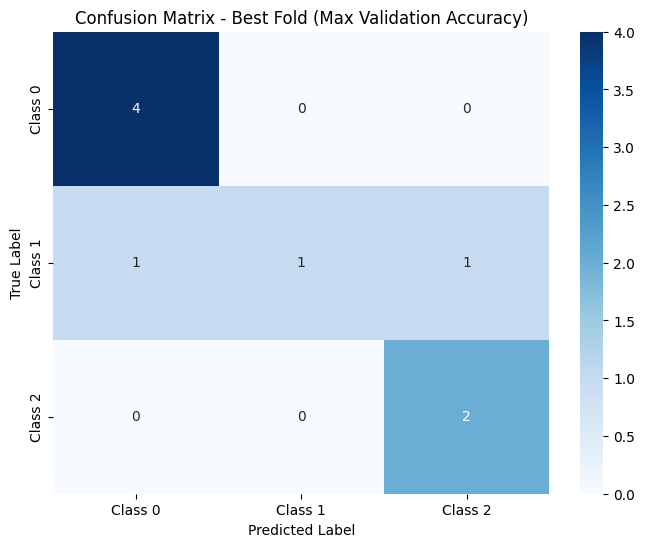

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      1.00      0.89         4
     Class 1       1.00      0.33      0.50         3
     Class 2       0.67      1.00      0.80         2

    accuracy                           0.78         9
   macro avg       0.82      0.78      0.73         9
weighted avg       0.84      0.78      0.74         9



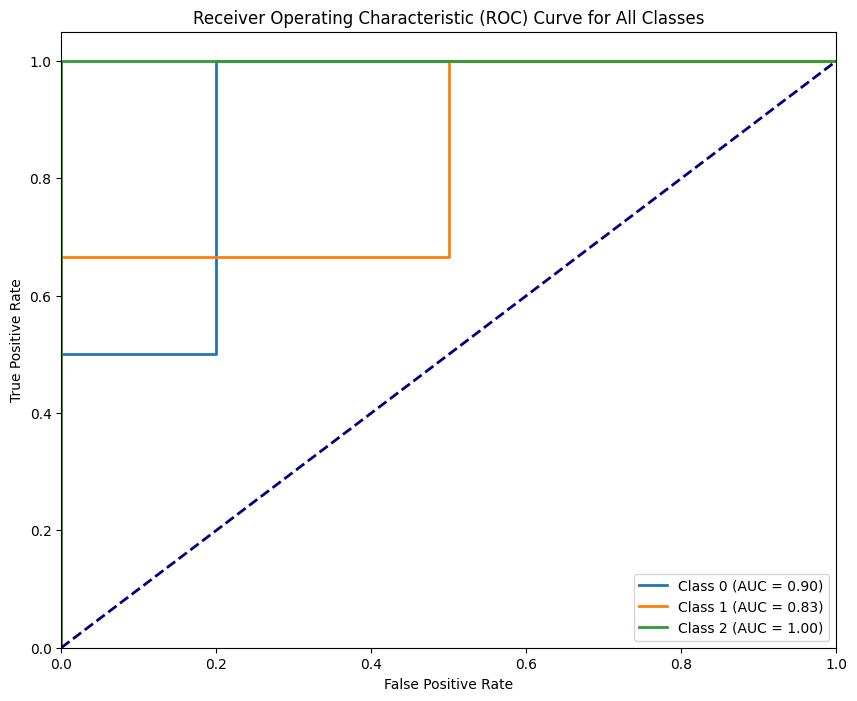

Accuracy: 0.7778
Precision: 0.8370
Recall: 0.7778
F1-Score: 0.7395


In [42]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

# Example of data (replace this with your actual data)
# X_eeg, X_clinical, X_images, y_labels should be preprocessed data arrays

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=10)

# Hyperparameters (example values, adjust as needed)
best_hyperparameters = {
    'lstm_units': 64,
    'dropout_rate': 0.2,
    'dense_units': 128,
    'dense_2_units': 64,
    'learning_rate': 0.001
}

# Initialize variables to track the best fold
best_fold_index = -1
best_val_accuracy = 0
best_y_true = None
best_y_pred = None
best_model = None
fold_accuracies = []

# Start the cross-validation process
for fold_no, (train_index, val_index) in enumerate(skf.split(X_eeg, y_labels.argmax(1))):
    print(f"Training fold {fold_no + 1}...")

    # Split data into training and validation sets
    X_train_eeg, X_val_eeg = X_eeg[train_index], X_eeg[val_index]
    X_train_clinical, X_val_clinical = X_clinical[train_index], X_clinical[val_index]
    X_train_images, X_val_images = X_images[train_index], X_images[val_index]
    y_train, y_val = y_labels[train_index], y_labels[val_index]

    # Define the model for this fold
    eeg_input = Input(shape=(X_train_eeg.shape[1], X_train_eeg.shape[2]), name='eeg_input')
    x1 = LSTM(best_hyperparameters['lstm_units'], return_sequences=False)(eeg_input)
    x1 = Dropout(best_hyperparameters['dropout_rate'])(x1)

    clinical_input = Input(shape=(X_train_clinical.shape[1],), name='clinical_input')
    x2 = Dense(best_hyperparameters['dense_units'], activation='relu')(clinical_input)
    x2 = Dropout(best_hyperparameters['dropout_rate'])(x2)

    image_input = Input(shape=(X_train_images.shape[1], X_train_images.shape[2]), name='image_input')
    x3 = Conv1D(64, kernel_size=3, activation='relu')(image_input)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Flatten()(x3)
    x3 = Dropout(best_hyperparameters['dropout_rate'])(x3)

    # Concatenate all inputs
    combined = Concatenate()([x1, x2, x3])

    # Dense layers
    x = Dense(best_hyperparameters['dense_2_units'], activation='relu')(combined)
    x = Dropout(best_hyperparameters['dropout_rate'])(x)

    # Output layer
    output = Dense(3, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=[eeg_input, clinical_input, image_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the training data
    model.fit([X_train_eeg, X_train_clinical, X_train_images], y_train, epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on the validation data
    val_loss, val_accuracy = model.evaluate([X_val_eeg, X_val_clinical, X_val_images], y_val, verbose=0)
    print(f"Validation accuracy for fold {fold_no + 1}: {val_accuracy:.4f}")

    # Save fold accuracy for averaging
    fold_accuracies.append(val_accuracy)

    # Store the model and results for the fold with the maximum validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_fold_index = fold_no
        best_y_true = y_val
        best_y_pred = model.predict([X_val_eeg, X_val_clinical, X_val_images])
        best_model = model

# Print overall results
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"Mean validation accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation: {std_accuracy:.4f}")

# After cross-validation, we have the best model for the highest validation accuracy fold

# Confusion Matrix
cm = confusion_matrix(best_y_true.argmax(1), best_y_pred.argmax(1))

# Classification Report
class_report = classification_report(best_y_true.argmax(1), best_y_pred.argmax(1), target_names=['Class 0', 'Class 1', 'Class 2'])

# Displaying Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix - Best Fold (Max Validation Accuracy)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display Classification Report
print("Classification Report:")
print(class_report)

# ROC and AUC for all classes
# Binarize the true labels
y_true_bin = label_binarize(best_y_true.argmax(1), classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))

# Loop through each class and plot ROC curve
for i in range(y_true_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], best_y_pred[:, i])  # For each class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve for all classes
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Classes')
plt.legend(loc='lower right')
plt.show()

# Additional Metrics Calculation
y_pred_labels = np.argmax(best_y_pred, axis=1)
y_true_labels = np.argmax(best_y_true, axis=1)

# Accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


## 8. FPGA Deliverables